Moving to another notebook so less messy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.optimize import leastsq
from craftroom import resample



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

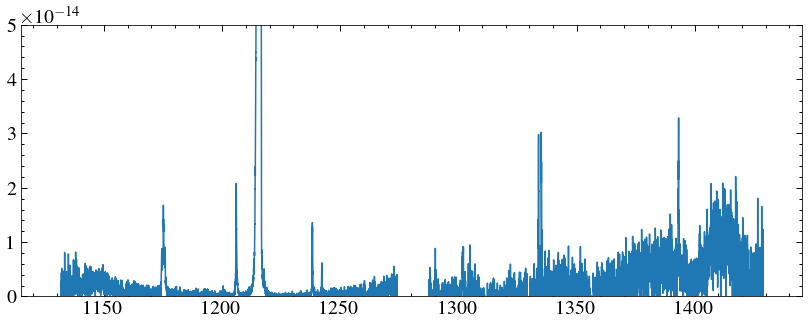

In [4]:

def residuals(scale, f, mf):
    return f - mf/scale


mw, mf = np.loadtxt('../models/DA_EG-UMA.dk', unpack=True, skiprows=34)

path = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x = glob.glob('{}*x1dsum.fits'.format(path))[0]

smooth=5
data = fits.getdata(x, 1)
w = np.array([], dtype=float)
f = np.array([], dtype=float)
e = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    w = np.concatenate((w, wi))
    f = np.concatenate((f, fi))
    e = np.concatenate((e, ei))    

f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)

mask = (w < 1213) | (w > 1217)
w1, f1 = w[mask], f[mask]
mmask = (mw > w1[0]) & (mw < w1[-1])
mw1, mf1 = mw[mmask], mf[mmask]

mf2 = interp1d(mw1, mf1, fill_value='extrapolate')(w1)
normfac = leastsq(residuals, 1., args=(f1, mf2))[0]


mf3 = interp1d(mw1, mf1, fill_value='extrapolate')(w)
f2 = f-(mf3/normfac)

plt.plot(w, f2)
#plt.xlim(1320, 1350)
plt.ylim(0, 5e-14)
plt.show()

In [5]:
linelist = Table.read('eg_uma_line_fluxes.ecsv')
lyatab = Table.read('EGUMa_LyA_ISM_estimate.txt', format='ascii.basic')

In [6]:
np.mean(linelist['VELOCITY'])

-144.54337475258342

In [7]:
lyatab.dtype.names

('wave',
 'flux_0kms',
 'flux_-120kms',
 'flux_-130kms',
 'flux_-140kms',
 'flux_-150kms',
 'ISM_attenuation')

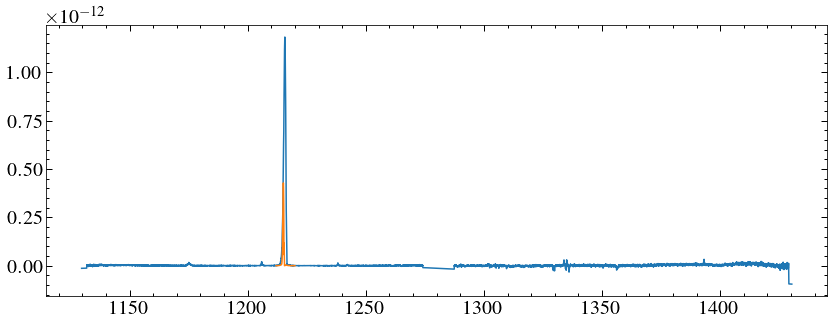

In [8]:
plt.plot(w, f2)
#plt.ylim(0, 5e-14)
plt.plot(lyatab['wave'], lyatab['flux_-140kms']*lyatab['ISM_attenuation'])

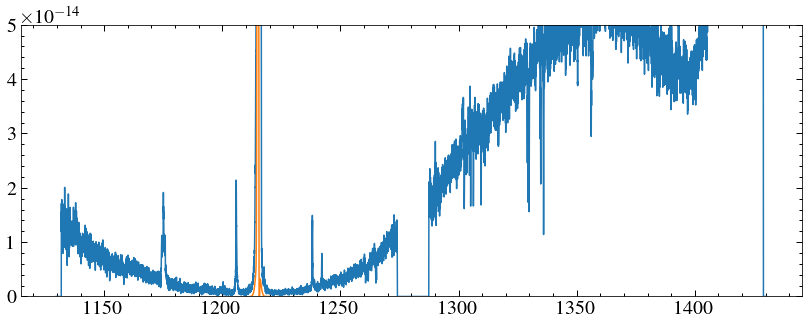

In [9]:
plt.plot(w, f)
plt.ylim(0, 5e-14)
plt.plot(lyatab['wave'], lyatab['flux_-140kms']*lyatab['ISM_attenuation'])

Great, so that will really show up over the g140m airglow.  
- Measure COS airglow and see how much the lya is contributing
- Grab a M4 g140m spectrum and mark the airglow

In [10]:
#data.names

In [11]:
#for dt in data[::-1]:
 #   plt.plot(dt['WAVELENGTH'], dt['BACKGROUND'])
  #  plt.plot(dt['WAVELENGTH'], dt['GROSS'])
    

In [12]:
spath = path +'stis_comparison/'
x2ds = glob.glob('{}*x2d.fits'.format(spath))
print(x2ds)
x1ds = glob.glob('{}*x1d.fits'.format(spath))
print(x1ds)


['/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131050_x2d.fits', '/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131060_x2d.fits', '/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131070_x2d.fits']
['/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131050_x1d.fits', '/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131060_x1d.fits', '/media/david/5tb_storage1/pceb_data/eg_uma/stis_comparison/ock131070_x1d.fits']


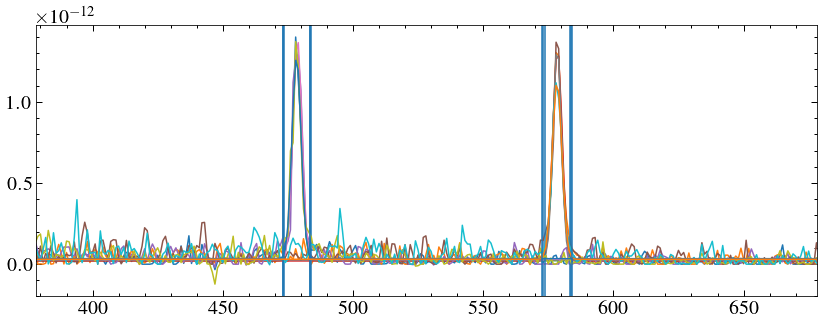

In [13]:
fitter = fitting.LevMarLSQFitter()

means = []
stds = []

for x2, x1 in zip(x2ds, x1ds):
    data2d = fits.getdata(x2,1)
    a2center = fits.getdata(x1,1)['a2center']
    xaxis = np.arange(len(data2d[0]))
    plt.plot(xaxis,data2d[int(a2center)+30])
    plt.plot(xaxis+100, data2d[int(a2center)-30])
    
    
    gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-12, 480,1, bounds=dict(amplitude=[0,1]))
    fit1 = fitter(gg_init, np.arange(len(data2d[0])),data2d[int(a2center)+30] , maxiter=10000)
    plt.plot(xaxis, fit1(xaxis))
    m1, std1 = fit1[1].mean, fit1[1].stddev
    plt.axvline(m1-3*std1)
    plt.axvline(m1+3*std1)
    
    fit2 = fitter(gg_init, np.arange(len(data2d[0])),data2d[int(a2center)-30] , maxiter=10000)
    plt.plot(xaxis+100, fit2(xaxis))
    m2, std2 = fit2[1].mean+100, fit2[1].stddev
    plt.axvline(m2-3*std2)
    plt.axvline(m2+3*std2)
    
    stds.append(std1.value)
    stds.append(std2.value)
    means.append(m1.value)
    means.append(m2)
    plt.xlim(m1 -100, m1+200)
    #plt.show()

In [14]:
center, dist = np.mean(np.array(means)), 3*np.mean(np.array(stds))
print(center, dist)

528.4652585164207 5.242857269149936


In [15]:
dist_eg_uma = 1/(34.83367384548251e-3)
dist_1214 = 1/(68.26534018946352e-3)
scale = (dist_eg_uma/dist_1214)**2

0.5551980180223416


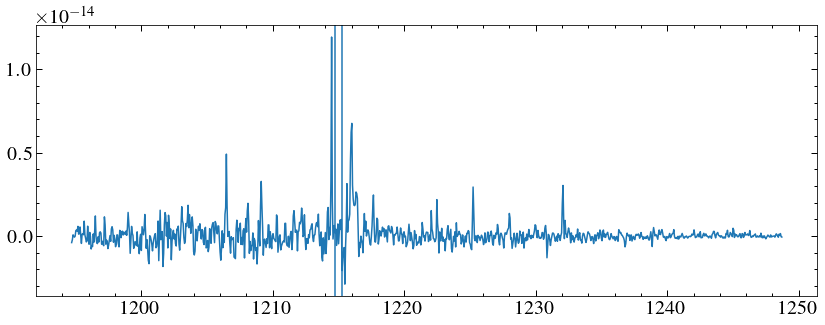

In [16]:
d1214 = fits.getdata('hlsp_muscles_hst_stis_gj1214_g140m_v22_component-spec.fits',1)
w1214, f1214 = d1214['WAVELENGTH'], d1214['FLUX']
plt.plot(w1214, f1214)
pix = (w1214[-1]-w1214[0])/len(w1214) 
plt.axvline(1215-dist*pix)
plt.axvline(1215+dist*pix)
print(2*dist*pix)

In [17]:
lyatab.dtype.names

('wave',
 'flux_0kms',
 'flux_-120kms',
 'flux_-130kms',
 'flux_-140kms',
 'flux_-150kms',
 'ISM_attenuation')

1215.9475990090114
1215.3924009909888


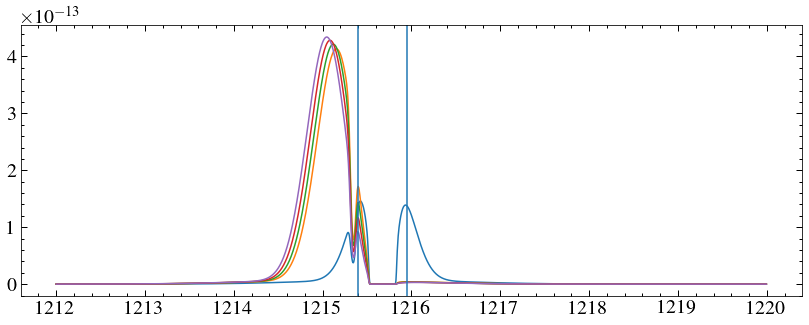

In [79]:
for name in lyatab.dtype.names[1:-1]:
    plt.plot(lyatab['wave'], lyatab[name]*lyatab['ISM_attenuation'])
plt.axvline(1215.67-dist*pix)
plt.axvline(1215.67+dist*pix)
print(1215.67+dist*pix)
print(1215.67-dist*pix)
#plt.yscale('log')

In [19]:
lines = Table.read('eg_uma_line_fluxes.ecsv')
lines[1:4]

ION,WAVELENGTH,FLUX,ERROR,VELOCITY
,Angstrom,erg / (cm2 s),erg / (cm2 s),km / s
str13,float64,float64,float64,float64
Si III,1206.499,1.0863578830616531e-14,3.9206275616522275e-16,-140.03862335433422
N V,1238.821,3.1340454758822476e-15,2.638940399145212e-16,-155.24755024466256
N V,1242.804,1.3773543256425523e-15,3.084272144908859e-16,-151.28399294794775


0.0
1215.4219999999805
-120.0
1215.1519999999807
-130.0
1215.1219999999807
-140.0
1215.0819999999808
-150.0
1215.0419999999808


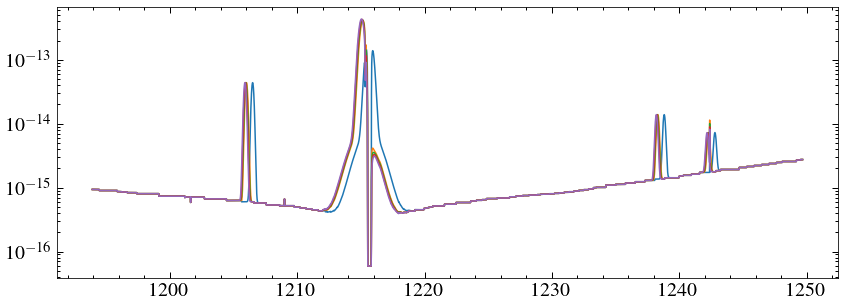

In [27]:
#making a model g140m spectrum for each velocity that I can put into the etc
lyaw = lyatab['wave']

#first interpolate model onto a finer grid
cmask = (mw > 1193) & (mw <1250)
wcut, fcut = mw[cmask], mf[cmask]/normfac

wcut, fcut = resample.bintogrid(wcut, fcut,dx=0.01)
#cmask =  (wcut < lyaw[0]) | (wcut > lyaw[-1]) 
#wcut, fcut = wcut[cmask], fcut[cmask]
#modw = np.concatenate((wcut, lyaw))
#args = np.argsort(modw)
#modw = modw[args]   
modw = wcut

for name in lyatab.dtype.names[1:-1]:
    lyaf = lyatab[name]*lyatab['ISM_attenuation']
    #print(name)
    #print(name[5:-3])
    #modf = np.concatenate((fcut, lyaf))
    #modf = modf[args]
    #plt.plot(lyaw, lyaf)
    lyaf = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(modw)
    #plt.plot(modw, lyaf)
    
    linemod = models.Const1D(0)
    for line in lines[1:4]:
        amp = line['FLUX']/(0.1*(2*np.pi)**0.5)
        mean = (float(name[5:-3])*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(line['WAVELENGTH']*u.AA))
        linemod += models.Gaussian1D(amp, mean.value, 0.1)
    modf = fcut+lyaf + linemod(modw)
    

    plt.plot(modw, modf)
 
    print(float(name[5:-3]))
    print(modw[np.argmax(modf)])
    
    savdat = Table([modw, modf], names=['#WAVELENGTH', 'FLUX'])
    ascii.write(savdat, 'etc_input_models/model_g140m_{}kms.dat'.format(name[5:-3]), overwrite=True, format='basic')
plt.yscale('log') 

(0.0, 1e-13)

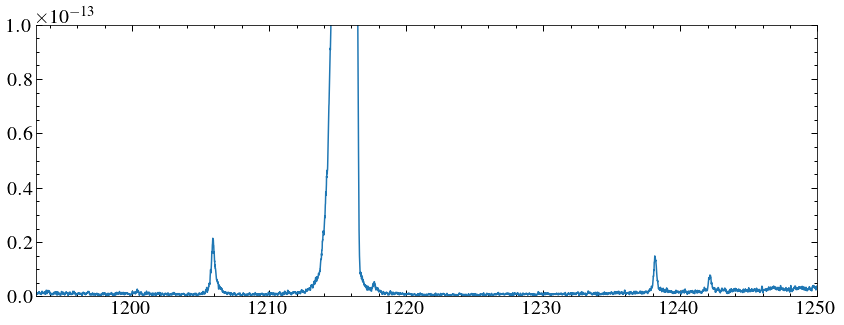

In [21]:
plt.plot(w,f)
plt.xlim(1193, 1250)
plt.ylim(0, 1e-13)

http://etc.stsci.edu/etc/results/STIS.sp.1462965/ says 131 seconds for S/N 10 at the lyman alpha line for 150 kms. Use orbital data to work out time at each phase. Need period, net velocity and orbital velocity ampltude... values from https://ui.adsabs.harvard.edu/abs/1987AJ.....94..996S/abstract

57678.6 s


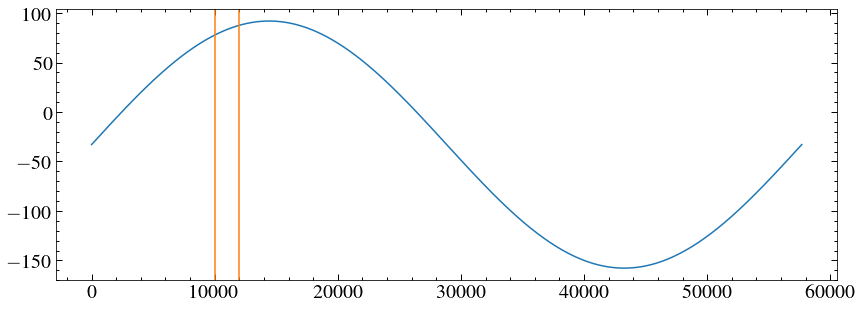

In [22]:
gamma = -32.9*u.km/u.s
k2 = 124.9*u.km/u.s
p = 961.31*u.min
ps = p.to(u.s)
print(ps)
model_orbit = models.Sine1D(k2, 1/ps)+models.Const1D(gamma)
model_time = np.arange(0, ps.value+1, 1)*u.s
plt.plot(model_time, model_orbit(model_time))
plt.axvline(10000, c='C1')
plt.axvline(12000, c='C1')

In [23]:
model_curve = model_orbit(model_time).value

vs = np.arange(-160, 110, 10)
print(vs)
times = []
for i in range(len(vs[:-1])):
    mask = (model_curve >= vs[i]) & (model_curve <vs[i+1])
    tv = model_time[mask]
    tinv = len(tv)
    #print('{}--{}={}'.format(vs[i], vs[i+1], tinv))
    times.append(tinv)
np.sum(times)

[-160 -150 -140 -130 -120 -110 -100  -90  -80  -70  -60  -50  -40  -30
  -20  -10    0   10   20   30   40   50   60   70   80   90  100]


57680

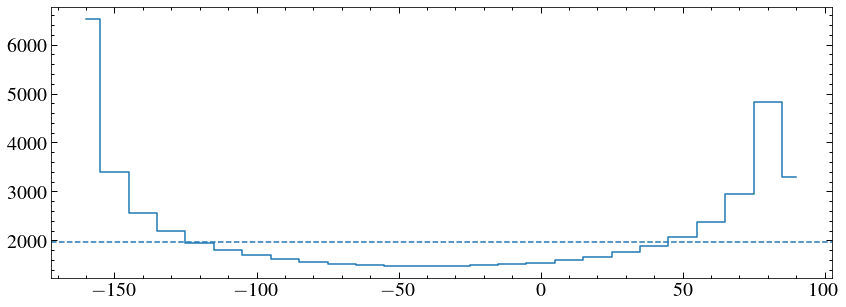

In [24]:
plt.step(vs[:-1], times, where='mid')
plt.axhline(1970, ls='--')

In [25]:
p.to(u.h)

<Quantity 16.02183333 h>

An entire orbit at each velocity gives S/N =40 for the peak! http://etc.stsci.edu/etc/results/STIS.sp.1462977/

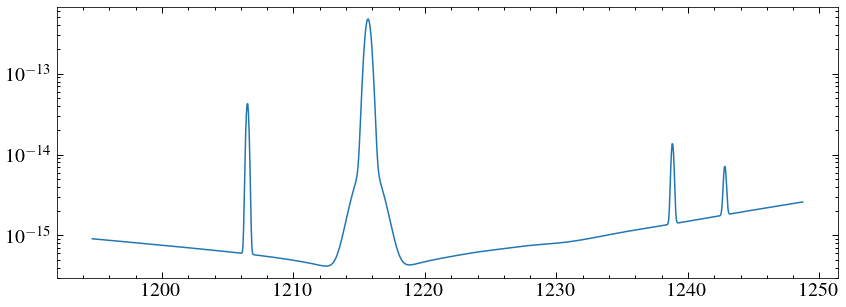

In [132]:
#make a zero_velocity, no ism model to make a gif

lyaw = lyatab['wave']

#first interpolate model onto a finer grid
cmask = (mw > 1193) & (mw <1250)
wcut, fcut = mw[cmask], mf[cmask]/normfac
#modw = np.arange(wcut[0], wcut[-1]+0.01, 0.01)
modw = w1214
fcut = interp1d(wcut, fcut, fill_value='extrapolate')(modw)
#plt.plot(modw, fcut)
#plt.show()

#wcut, fcut = resample.bintogrid(wcut, fcut,dx=0.01)
#cmask =  (wcut < lyaw[0]) | (wcut > lyaw[-1]) 
#wcut, fcut = wcut[cmask], fcut[cmask]
#modw = np.concatenate((wcut, lyaw))
#args = np.argsort(modw)
#modw = modw[args]   
#modw = wcut

lyaf = lyatab['flux_0kms']
#print(name)
#print(name[5:-3])
#modf = np.concatenate((fcut, lyaf))
#modf = modf[args]
#plt.plot(lyaw, lyaf)
lyaf = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(modw)
#plt.plot(modw, lyaf)

linemod = models.Const1D(0)
for line in lines[1:4]:
    amp = line['FLUX']/(0.1*(2*np.pi)**0.5)
    mean = (line['WAVELENGTH']*u.AA)
    linemod += models.Gaussian1D(amp, mean.value, 0.1)
modf = lyaf + linemod(modw)


plt.plot(modw, modf+fcut)

plt.yscale('log') 

In [133]:
etc = Table.read('etc1orb.csv')
etc.dtype.names


('wavelength',
 'readnoise',
 'dark_counts',
 'sky_counts',
 'target_counts',
 'total_counts')

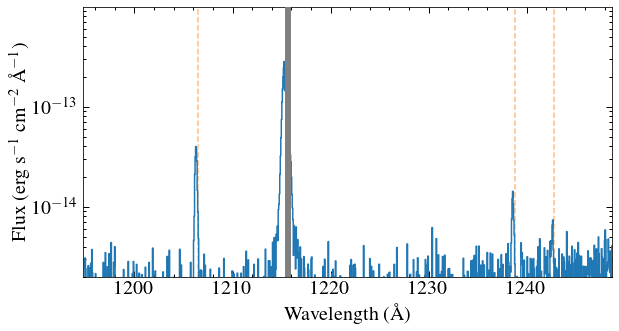

In [134]:
from matplotlib.animation import FuncAnimation
#smooth=50

model_obs = np.arange(0, ps.value+1, 2000)*u.s
dvs = model_orbit(model_obs)
#dvs = np.hstack((np.arange(-160, 110, 10), np.arange(110, -160, -10)))



fig, ax = plt.subplots(figsize=(9,5))
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
#ax[0].set_ylim(0.4, 1.2)
ax.set_xlim(modw[0], modw[-1])
ax.set_ylim(2e-15, 9.9e-13)
ax.set_yscale('log')

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
#ax.axvline(1393.775, ls='--', c='C1', alpha=0.5)
#ax.axvline(1402.770, ls='--', c='C1', alpha=0.5)
[ax.axvline(line, ls='--', c='C1', alpha=0.5) for line in [1206.499 ,1238.821, 1242.804]]
#ax.fill_between([1215.392, 1215.948],0, 1, facecolor = 'k')
#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
line1, = ax.step(w,f, where='mid')
#std = np.max(modf)/200 #peak sn = 40 for one orbit 
ax.fill_between([1215.392, 1215.948],0, 1, facecolor = '0.5', zorder=100)#, alpha=0.5)

sn = (etc['target_counts']/(etc['total_counts']-etc['target_counts']))
sn = interp1d(etc['wavelength'], sn, fill_value='extrapolate')(modw)

ism = interp1d(lyaw, lyatab['ISM_attenuation'], bounds_error=False, fill_value=0.96)(modw)
def update(i):
    dv = dvs[i]
    wi = (dv).to(u.AA, equivalencies=u.doppler_optical(modw*u.AA))
    fi = interp1d(wi, modf, bounds_error=False, fill_value=0)(modw)
    fi *= ism
    fi += fcut
    fi = np.random.normal(fi, max(fi)/200)
    
    line1.set_xdata(modw)
    line1.set_ydata(fi)
    
   ## if ti > t0+2:
     #   t0 = ti
      #  obs =
   # an.set_text('Ob {0}'.format(obs))
 #   print(ti)
    return ax, line1#, an
#ax.legend()
anim = FuncAnimation(fig, update, frames=np.arange(len(dvs)), interval=100)
anim.save('eguma_g140m_sim.gif', dpi=100, writer='imagemagick')
plt.show()



In [135]:
#plt.plot(etc['wavelength'], etc['target_counts']/(etc['total_counts']-etc['target_counts']))
#plt.yscale('log')
#plt.axhline(1)

In [136]:
#np.max(etc['target_counts']/(etc['total_counts']-etc['target_counts']))

In [137]:
len(model_obs)

29

What's the best time to observe, and what is the mean dv of those times? Do we get 0kms or 0 phase? Do we have a choice? Need to get the ephemeris from TESS.

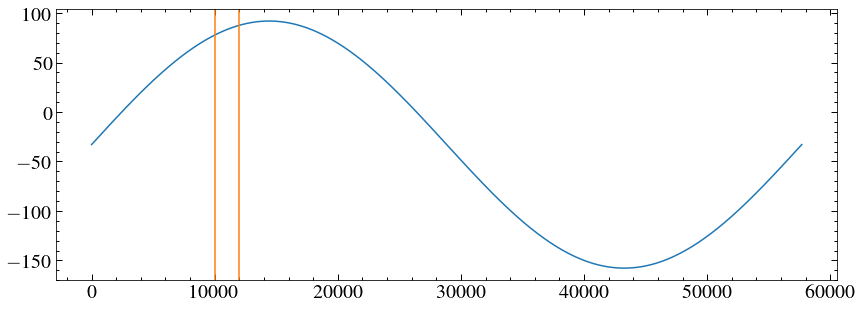

In [141]:
exp = 2000#s, roughly the COS EXPTIME

t1 = 

model_time = np.arange(0, ps.value+1, 1)*u.s
plt.plot(model_time, model_orbit(model_time))
#plt.axvline(10000, c='C1')
#plt.axvline(12000, c='C1')